In [21]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import torchvision

In [3]:
train_transform = [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
train_transform = transforms.Compose(train_transform)
num_workers = 0
batch_size = 40
train_data = datasets.MNIST(root='../data', train= True, download=False, transform=train_transform)
valid_data = datasets.MNIST(root='../data', train= True, download=False, transform=train_transform)
test_data = datasets.MNIST(root='../data', train= False, download=False, transform=train_transform)

C:\Users\prabh\anaconda3\envs\boston_house_prices_prediction\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
num_train = len(train_data)
data_idx = list(range(num_train))
split_idx = int(num_train * 0.05)
train_idx, valid_idx = data_idx[split_idx:], data_idx[:split_idx]

In [5]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size= batch_size,
                                           sampler = train_sampler,
                                           num_workers= num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size= batch_size,
                                           sampler = valid_sampler,
                                           num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size = batch_size, 
                                          num_workers = num_workers)

In [7]:
dataiter = iter(train_loader)
img, lbl = dataiter.next()
img.shape

torch.Size([40, 1, 28, 28])

In [9]:
learning_rate = 0.01

In [10]:
writer = SummaryWriter(f"runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")

In [11]:
# Declaring a neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = F.relu(self.fc1(x.view(batch_size,28*28)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x
model = Net()
print(f'Total elements in the network : {sum([p.numel() for p in model.parameters()])}')

Total elements in the network : 407050


In [17]:
writer.add_graph(model, img)
writer.close()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [19]:
def validate_training():
    model.eval()
    valid_loss = 0.0    
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss / (len(valid_loader) * batch_size)
    print("Epoch {} : Validation loss : {:.6f}".format(epoch+1, valid_loss))
    return valid_loss

In [23]:
step = 0
per_epoch_loss = []
validation_error = []
accuracies = []
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    losses = []
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        _, predictions = output.max(1)
        num_correct = (predictions == target).sum()
        running_train_acc = float(num_correct) / float(data.shape[0])
        accuracies.append(running_train_acc)
        losses.append(loss.item())
        train_loss += loss.item() * data.size(0)
        features = data.reshape(data.shape[0], -1)
        img_grid = torchvision.utils.make_grid(data)
        writer.add_image("mnist_images", img_grid)
        writer.add_histogram("fc1", model.fc1.weight)
        writer.add_scalar("Training loss", loss, global_step=step)
        writer.add_scalar(
            "Training Accuracy", running_train_acc, global_step=step
        )
    train_loss = train_loss / len(train_loader.dataset)
    print("Epoch {} : Training loss : {:.6f}".format(epoch+1, train_loss))
    per_epoch_loss.append(train_loss)
    validation_error.append(validate_training())
    step += 1

Epoch 1 : Training loss : 0.329719
Epoch 1 : Validation loss : 0.310650
Epoch 2 : Training loss : 0.315984
Epoch 2 : Validation loss : 0.298213
Epoch 3 : Training loss : 0.302014
Epoch 3 : Validation loss : 0.286786
Epoch 4 : Training loss : 0.292121
Epoch 4 : Validation loss : 0.278030
Epoch 5 : Training loss : 0.282941
Epoch 5 : Validation loss : 0.269129
Epoch 6 : Training loss : 0.272911
Epoch 6 : Validation loss : 0.261510
Epoch 7 : Training loss : 0.265181
Epoch 7 : Validation loss : 0.254637
Epoch 8 : Training loss : 0.258033
Epoch 8 : Validation loss : 0.247925
Epoch 9 : Training loss : 0.251624
Epoch 9 : Validation loss : 0.241587
Epoch 10 : Training loss : 0.245690
Epoch 10 : Validation loss : 0.235725
Epoch 11 : Training loss : 0.238299
Epoch 11 : Validation loss : 0.230548
Epoch 12 : Training loss : 0.233146
Epoch 12 : Validation loss : 0.225519
Epoch 13 : Training loss : 0.227616
Epoch 13 : Validation loss : 0.220770
Epoch 14 : Training loss : 0.221466
Epoch 14 : Validatio

In [24]:
writer.add_hparams(
                {"lr": learning_rate, "bsize": batch_size},
                {
                    "accuracy": sum(accuracies) / len(accuracies),
                    "loss": sum(losses) / len(losses),
                },
            )
writer.close()

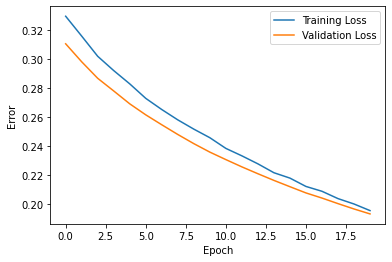

In [25]:
plt.plot(np.arange(20), per_epoch_loss, label='Training Loss')
plt.plot(np.arange(20), validation_error, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()